In [20]:
import tensorflow as tf
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import keras_tuner as kt

# constantes
BATCH_SIZE = 32
EPOCHS = 300
NEURONS = 100
LAYERS = 5
VAL_SIZE = 0.2
TEST_SIZE = 0
MODE = "polar" # "polar" or "cartesian"

def set_parameters(batch_size = 32, epochs = 300, learning_rate = 0.1, neurons = 100, layers = 5):
  global BATCH_SIZE, EPOCHS, LEARNING_RATE, NEURONS, LAYERS
  BATCH_SIZE = batch_size
  EPOCHS = epochs
  LEARNING_RATE = learning_rate
  NEURONS = neurons
  LAYERS = layers

if MODE == "polar":
  train_data = pd.read_csv('train_polar.csv')
  test_data_final = pd.read_csv('test_polar.csv')
else:
  train_data = pd.read_csv('train.csv')
  test_data_final = pd.read_csv('test_x.csv')

print(train_data.shape)
print(test_data_final.shape)

(3000, 3)
(1500, 3)


In [7]:
from sklearn.model_selection import train_test_split

# Generate a validation set from the training data, taking VAL_SIZE*100% of the data

train_data = train_data.sample(frac=1).reset_index(drop=True)

# Split the data into train and test sets
if TEST_SIZE > 0:
    train_data, test_data = train_test_split(train_data, test_size=TEST_SIZE)
    print(test_data.shape)

if VAL_SIZE > 0:
    train_data, val_data = train_test_split(train_data, test_size=VAL_SIZE/(1-TEST_SIZE))
    print(val_data.shape)

print(train_data.shape)

(600, 3)
(2400, 3)


In [8]:
if TEST_SIZE > 0:
    # Save the labels of the test set
    test_labels = test_data['Category']

    if 'Category' in test_data.columns:
        test_data = test_data.drop(['Category'], axis=1)
        print(test_data.shape)
# Split the data into coordinates and labels
if MODE == "polar":
    features_train = ['r', 'theta']
else:
    features_train = ['x1', 'x2']
x_train = train_data[features_train]
y_train = train_data['Category']
print(x_train.shape)
print(y_train.shape)

(2400, 2)
(2400,)


In [51]:
from tensorflow.keras import regularizers

# FEEDFORWARD NEURAL NETWORK
acc = 0.0
count = 0
while acc < 0.97 and count < 3:
    mc =  EarlyStopping(monitor='accuracy', min_delta=0, patience=10, restore_best_weights=True)

    set_parameters(batch_size=1, epochs=300)

    input = tf.keras.Input(shape=(2,))
    hidden = tf.keras.layers.Dense(32, activation='relu')(input)
    hidden2 = tf.keras.layers.Dense(16, activation='relu')(hidden)
    hidden3 = tf.keras.layers.Dense(8, activation='relu')(hidden2)
    hidden4 = tf.keras.layers.Dense(8, activation='relu')(hidden3)
    output = tf.keras.layers.Dense(3, activation='softmax')(hidden4)
    model = tf.keras.Model(inputs=input, outputs=output)
    #model.summary()
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    history = model.fit(x_train, y_train, verbose=1, epochs=EPOCHS, validation_data=(val_data[features_train], val_data['Category']), batch_size=BATCH_SIZE, callbacks=[mc])
    acc = history.history['val_accuracy'][-1]
    count += 1

Epoch 1/300
2400/2400 [==============================] - 4s 1ms/step - loss: 1.0957 - accuracy: 0.3554 - val_loss: 1.1218 - val_accuracy: 0.3817
Epoch 2/300
2400/2400 [==============================] - 3s 1ms/step - loss: 1.0712 - accuracy: 0.3783 - val_loss: 1.0795 - val_accuracy: 0.3550
Epoch 3/300
2400/2400 [==============================] - 3s 1ms/step - loss: 1.0442 - accuracy: 0.4054 - val_loss: 1.0454 - val_accuracy: 0.4483
Epoch 4/300
2400/2400 [==============================] - 3s 1ms/step - loss: 0.9941 - accuracy: 0.4567 - val_loss: 0.9999 - val_accuracy: 0.4583
Epoch 5/300
2400/2400 [==============================] - 3s 1ms/step - loss: 0.9523 - accuracy: 0.5021 - val_loss: 0.9640 - val_accuracy: 0.4650
Epoch 6/300
2400/2400 [==============================] - 3s 1ms/step - loss: 0.8871 - accuracy: 0.5462 - val_loss: 0.8817 - val_accuracy: 0.5267
Epoch 7/300
2400/2400 [==============================] - 3s 1ms/step - loss: 0.8029 - accuracy: 0.6121 - val_loss: 0.7855 - val_ac

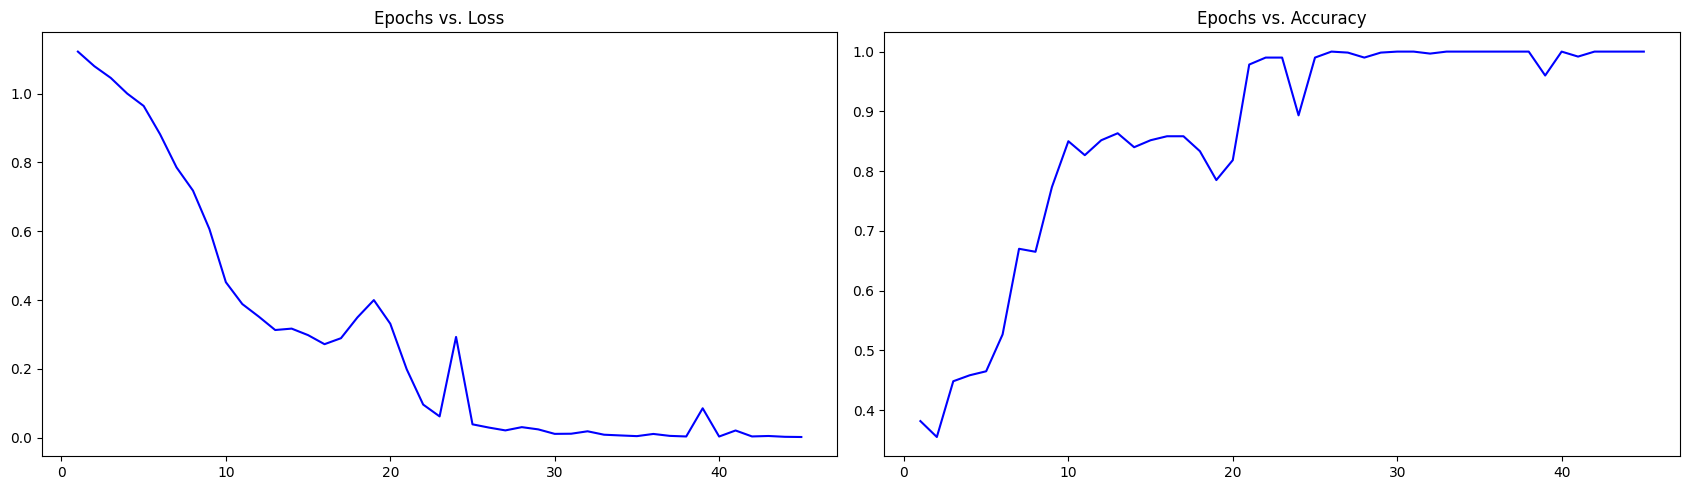

In [52]:
epoch_count = range(1, len(history.history['loss']) + 1)
fig, axis = plt.subplots(1,2,figsize=(17,5))
axis[0].plot(list(epoch_count),history.history['val_loss'],color='b')
axis[1].plot(list(epoch_count),history.history['val_accuracy'],color='b')
axis[0].set_title("Epochs vs. Loss")
axis[1].set_title("Epochs vs. Accuracy")
plt.tight_layout()
plt.show()

In [11]:
if TEST_SIZE > 0:
    # Generate probability predictions on the test set
    test_prob_predictions = model.predict(test_data)

    # Get the predicted class for each instance
    test_predictions = test_prob_predictions.argmax(axis=1)

    # Evaluate the predictions using a suitable metric
    from sklearn.metrics import accuracy_score
    test_accuracy = accuracy_score(test_labels, test_predictions)

    # Print the test accuracy
    print(f"Test accuracy: {test_accuracy}")

In [28]:
model_guardar = tf.keras.Model(inputs=input, outputs=output) 
model_guardar.summary()
model_guardar.save('model.h5')

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_14 (Dense)            (None, 4)                 12        
                                                                 
 dense_15 (Dense)            (None, 4)                 20        
                                                                 
 dense_16 (Dense)            (None, 3)                 15        
                                                                 
Total params: 47
Trainable params: 47
Non-trainable params: 0
_________________________________________________________________


In [36]:
if 'Id' in test_data_final.columns:
    test_data_final = test_data_final.drop(['Id'], axis=1)
    print("id eliminado")


print(test_data_final.shape)

predictions = model.predict(test_data_final)
predictions

#predecir clase del primer elemento en test_data
predictions[0]
np.argmax(predictions[0])

len_test_data = len(test_data_final)

f = open('pred.csv', 'w+')
f.write('Id,Category\n')

for i in range(len_test_data):
    f.write(str(i) + "," + str(np.argmax(predictions[i])) + '\n')

f.close()

(1500, 2)
47/47 [==============================] - 0s 1ms/step


In [23]:
# USING KERAS TUNER

def modelo_a_tunear(tuner):
  # Capas del modelo
  input = tf.keras.Input(shape=(2))
  for i in range(1, tuner.Int("num_layers", 2, 3)):
    if i==1:
      x = tf.keras.layers.Dense(units=tuner.Int("units_" + str(i), min_value=2, max_value=5, step=1),
              activation='swish')(input)
    else:
      x = tf.keras.layers.Dense(units=tuner.Int("units_" + str(i), min_value=2, max_value=5, step=1),
              activation='swish')(x)
  outputs_tunner = tf.keras.layers.Dense(3, activation='softmax')(x)
  # Modelo
  model_tunner = tf.keras.Model(inputs=input, outputs=outputs_tunner)
  # Learning Rate
  learning_rate_tuneada = tuner.Choice("learning_rate", values=[0.1, 0.01])
  model_tunner.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_tuneada),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
  return model_tunner

hypertuner = kt.Hyperband(modelo_a_tunear,
                     objective='val_accuracy',
                     max_epochs=100,
                     factor=3,
                     directory='.',
                     project_name='optimal_values')


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

hypertuner.search(x_train, y_train, epochs=100, validation_data=(val_data[features_train], val_data['Category']), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=hypertuner.get_best_hyperparameters(num_trials=100)[0]

print(f"""{best_hps.values}.""")

Trial 65 Complete [00h 00m 01s]
val_accuracy: 0.4000000059604645

Best val_accuracy So Far: 0.5649999976158142
Total elapsed time: 00h 01m 11s
INFO:tensorflow:Oracle triggered exit
{'num_layers': 2, 'units_1': 5, 'learning_rate': 0.01, 'units_2': 2, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 4, 'tuner/round': 0}.
